# Calibration of the logistic model

In this example, we calibrate the parameters of a model which predicts the dynamics of the size of a population depending on the time in a given time interval. This shows how a model which predicts a time dependent output can be calibrated by managing the dynamics as a vector output of the model.

## Introduction

The logistic growth model is the differential equation:

$$
\frac{dy(t)}{dt} = ay(t) - by(t)^2
$$

for any $t\in[t_0, t_{final}]$, with the initial condition:

$$
y(t_0) = y_0
$$

where

- $a > 0$ and $b > 0$ are two real parameters, 
- $y(t)$ is the size of the population at time $t$, 
- $t_0$ is the initial time,
- $y_0$ is the initial population at time $t=t_0$, 
- $t_{final}$ is the final time.

The $a$ parameter sets the growth rate of the population. The $b$ parameter acts as a competition parameter which limits the size of the population by increasing the competition between its members. 

In [1], the author uses this model to simulate the growth of the U.S. population. To do this, the author uses the U.S. census data from 1790 to 1910. For this time interval, R. Pearl and L. Reed [2] computed the following values of the parameters:

$$
a = 0.03134, \qquad 
b = 1.5887 \times 10^{-10}.
$$

Our goal is to use the logistic growth model in order to simulate the solution for a larger time interval, from 1790 to 2000:

$$
t_0 = 1790, \qquad 
t_{final} = 2000.
$$

Then we can compare the predictions of this model with the real evolution of the U.S. population.

We can prove that, if $y_0 > 0$, then the limit population is:

$$
y_{limit} =\frac{a}{b}.
$$

In 1790, the U.S. population was 3.9 Millions inhabitants:

$$
y_0 = 3.9 \times 10^6.
$$

We can prove that the exact solution of the ordinary differential equation is:

$$
y(t)=\frac{ay_0}{by_0+(a-by_0 ) \exp(-a(t-t_0)) }
$$

for any $t\in[t_0, t_{final}]$.

We want to see the solution of the ordinary differential equation when uncertainties are taken into account in the parameters:

- the initial U.S. population $y_0$,
- the parameters $a$ and $b$.

Indeed, Pearl and Reed [2] estimated the parameters $a$ and $b$ using the U.S. census data from 1790 to 1910 while we have the data up to 2000. Moreover, the method used by Pearl and Reed to estimate the parameters could be improved; they only used 3 dates to estimate the parameters instead of using least squares, for example. Finally, Pearl and Reed did not provide confidence intervals for the parameters $a$ and $b$. 


## Normalizing the data

The order of magnitude of $a$ and $b$ are very different. In order to mitigate this, we consider the parameter $c$ as the logarithm of $b$:

$$
c = \log(b).
$$

This leads to the value:

$$
c = \log\left(1.5887 \times 10^{-10}\right) = -22.58.
$$

The order of magnitude of the population is $10^6$. This is why we consider the normalized population in millions:

$$
z(t) = \frac{y(t)}{10^6}
$$

for any $t\in[t_0, t_{final}]$.

Let $z_0$ be the initial population:

$$
z_0 = z(t_0).
$$

## Uncertainties

Uncertainty can be accounted for by turning $z_0$, $a$ and $c$ into independent random variables $Z_0$, $A$ and $C$ with Gaussian distributions. From this point onward, $z_0$, $a$ and $b$ respectively denote $\mathbb{E}[Z_0]$, $\mathbb{E}[A]$ and $\mathbb{E}[C]$.

|Variable|  Distribution|
| ------------- |-------------|
| $Z_0$ | gaussian, mean $z_0$, coefficient of variation 10% |
| $A$ | gaussian, mean $a$, coefficient of variation 30% |
| $C$ | gaussian, mean $c$, coefficient of variation 30% |

No particular probabilistic method was used to set these distributions. An improvement would be to use calibration methods to get a better quantification of these distributions. An improvement would be to use calibration methods to get a better quantification of these distributions. 

## Summary

The summary of this calibration study is the following.
* t: Input. Observed.
* $z_0$, a, c: Inputs. Calibrated.
* z: Output. Observed.

## Notes

* This example is based on [1], chapter "First order differential equations", page 28. 
The data used in [1] are from [3]. 
The logistic growth model was first suggested by Pierre François Verhulst near 1840. 
The data are from [1] for the time interval from 1790 to 1950, then from [2] for the time interval from 1960 to 2000.
* Calibrating this model may require to take into account for the time dependency of the measures.

## References

[1] Martin Braun. Differential equations and their applications, Fourth Edition. Texts in applied
mathematics. Springer, 1993.

[2] Cleve Moler. Numerical Computing with Matlab. Society for Industrial Applied Mathematics,
2004.

[3] Raymond Pearl and Lowell Reed. On the rate of growth of the population of the united states
since 1790 and its mathematical representation. Proceedings of the National Academy of Sciences,
1920.

## Analysis of the data

In [1]:
import openturns as ot
import numpy as np

The data is based on 22 dates from 1790 to 2000.

In [2]:
observedSample=ot.Sample([\
[1790,3.9], \
[1800,5.3], \
[1810,7.2], \
[1820,9.6], \
[1830,13], \
[1840,17], \
[1850,23], \
[1860,31], \
[1870,39], \
[1880,50], \
[1890,62], \
[1900,76], \
[1910,92], \
[1920,106], \
[1930,123], \
[1940,132], \
[1950,151], \
[1960,179], \
[1970,203], \
[1980,221], \
[1990,250], \
[2000,281]])

In [3]:
nbobs = observedSample.getSize()
nbobs

22

In [4]:
timeObservations = observedSample[:,0]
timeObservations[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v0] data=[[1790],[1800],[1810],[1820],[1830]]

In [5]:
populationObservations = observedSample[:,1]
populationObservations[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[v1] data=[[3.9],[5.3],[7.2],[9.6],[13]]

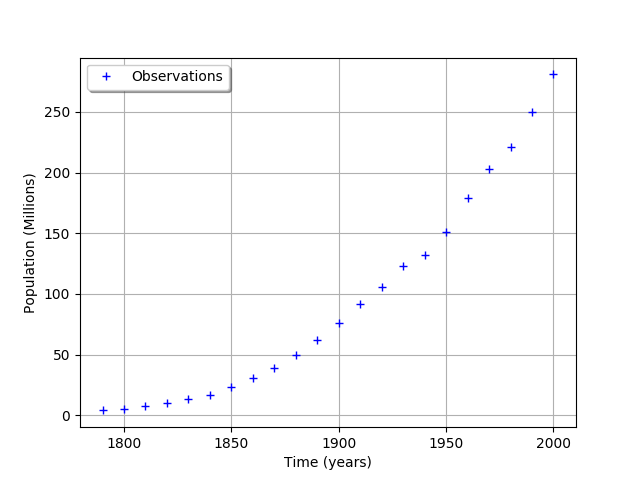

In [6]:
graph = ot.Graph('', 'Time (years)', 'Population (Millions)', True, 'topleft')
cloud = ot.Cloud(timeObservations, populationObservations)
cloud.setLegend("Observations")
graph.add(cloud)
graph

We consider the times and populations as dimension 22 vectors. The `logisticModel` function takes a dimension 24 vector as input and returns a dimension 22 vector. The first 22 components of the input vector contains the dates and the remaining 2 components are $a$ and $b$. 

In [7]:
def logisticModel(X):
    nbdates = 22
    t = [X[i] for i in range(nbdates)]
    a = X[22]
    c = X[23]
    t0 = 1790.
    y0 = 3.9e6
    b = np.exp(c)
    y = ot.Point(nbdates)
    for i in range(nbdates):
        y[i] = a*y0/(b*y0+(a-b*y0)*np.exp(-a*(t[i]-t0)))
    z = y/1.e6 # Convert into millions
    return z

In [8]:
logisticModelPy = ot.PythonFunction(24,22,logisticModel)

The reference values of the parameters. 

Because $b$ is so small with respect to $a$, we use the logarithm. 

In [9]:
np.log(1.5587e-10)

-22.581998789427587

In [10]:
a=0.03134
c=-22.58
thetaPrior = [a,c]

In [11]:
logisticParametric = ot.ParametricFunction(logisticModelPy,[22,23],thetaPrior)

Check that we can evaluate the parametric function.

In [12]:
populationPredicted = logisticParametric(timeObservations.asPoint())
populationPredicted

class=Point name=Unnamed dimension=22 values=[3.9,5.29757,7.17769,9.69198,13.0277,17.4068,23.0769,30.2887,39.2561,50.0977,62.7691,77.0063,92.311,108.001,123.322,137.59,150.3,161.184,170.193,177.442,183.144,187.55]

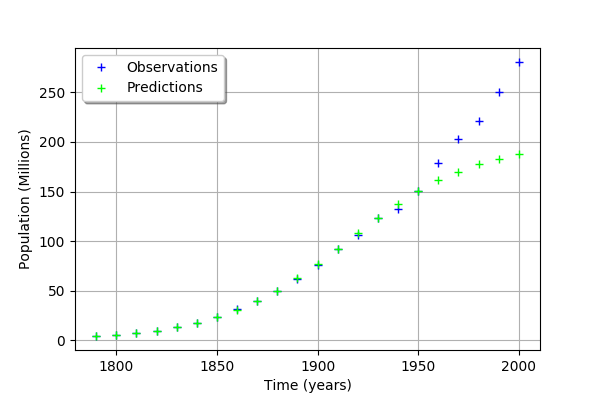

In [13]:
graph = ot.Graph('', 'Time (years)', 'Population (Millions)', True, 'topleft')
# Observations
cloud = ot.Cloud(timeObservations, populationObservations)
cloud.setLegend("Observations")
cloud.setColor("blue")
graph.add(cloud)
# Predictions
cloud = ot.Cloud(timeObservations.asPoint(), populationPredicted)
cloud.setLegend("Predictions")
cloud.setColor("green")
graph.add(cloud)
graph

We see that the fit is not good: the observations continue to grow after 1950, while the growth of the prediction seem to fade.

## A visualisation class

In [14]:
"""
A graphics class to analyze the results of calibration.
"""

import pylab as pl
import openturns as ot
import openturns.viewer as otv

class CalibrationAnalysis:
    def __init__(self,calibrationResult,model,inputObservations,outputObservations):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
    
        Parameters
        ----------
        calibrationResult : :class:`~openturns.calibrationResult`
            The result of a calibration.
    
        model : 2-d sequence of float
            The function to calibrate.
    
        inputObservations : :class:`~openturns.Sample`
            The sample of input values of the model linked to the observations.
    
        outputObservations : 2-d sequence of float
            The sample of output values of the model linked to the observations.
        """
        self.model = model
        self.outputAtPrior = None
        self.outputAtPosterior = None
        self.calibrationResult = calibrationResult
        self.observationColor = "blue"
        self.priorColor = "red"
        self.posteriorColor = "green"
        self.inputObservations = inputObservations
        self.outputObservations = outputObservations
        self.unitlength = 6 # inch
        # Compute yAtPrior
        meanPrior = calibrationResult.getParameterPrior().getMean()
        model.setParameter(meanPrior)
        self.outputAtPrior=model(inputObservations)
        # Compute yAtPosterior
        meanPosterior = calibrationResult.getParameterPosterior().getMean()
        model.setParameter(meanPosterior)
        self.outputAtPosterior=model(inputObservations)
        return None

    def drawParameterDistributions(self):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
        """
        thetaPrior = self.calibrationResult.getParameterPrior()
        thetaDescription = thetaPrior.getDescription()
        thetaPosterior = self.calibrationResult.getParameterPosterior()
        thetaDim = thetaPosterior.getDimension()
        fig = pl.figure(figsize=(12, 4))
        for i in range(thetaDim):
            graph = ot.Graph("",thetaDescription[i],"PDF",True,"topright")
            # Prior distribution
            thetaPrior_i = thetaPrior.getMarginal(i)
            priorPDF = thetaPrior_i.drawPDF()
            priorPDF.setColors([self.priorColor])
            priorPDF.setLegends(["Prior"])
            graph.add(priorPDF)
            # Posterior distribution
            thetaPosterior_i = thetaPosterior.getMarginal(i)
            postPDF = thetaPosterior_i.drawPDF()
            postPDF.setColors([self.posteriorColor])
            postPDF.setLegends(["Posterior"])
            graph.add(postPDF)
            '''
            If the prior is a Dirac, set the vertical axis bounds to the posterior. 
            Otherwise, the Dirac set to [0,1], where the 1 can be much larger 
            than the maximum PDF of the posterior.
            '''
            if (thetaPrior_i.getName()=="Dirac"):
                # The vertical (PDF) bounds of the posterior
                postbb = postPDF.getBoundingBox()
                pdf_upper = postbb.getUpperBound()[1]
                pdf_lower = postbb.getLowerBound()[1]
                # Set these bounds to the graph
                bb = graph.getBoundingBox()
                graph_upper = bb.getUpperBound()
                graph_upper[1] = pdf_upper
                bb.setUpperBound(graph_upper)
                graph_lower = bb.getLowerBound()
                graph_lower[1] = pdf_lower
                bb.setLowerBound(graph_lower)
                graph.setBoundingBox(bb)
            # Add it to the graphics
            ax = fig.add_subplot(1, thetaDim, i+1)
            _ = otv.View(graph, figure=fig, axes=[ax])
        return fig
    
    def drawObservationsVsPredictions(self):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        """
        
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        graph = ot.Graph("","Observations","Predictions",True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            graph = self._drawObservationsVsPredictions1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])

        return graph

    def _drawObservationsVsPredictions1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        Can manage only 1D samples.
        """
        yDim = outputObservations.getDimension()
        ydescription = outputObservations.getDescription()
        xlabel = "%s Observations" % (ydescription[0])
        ylabel = "%s Predictions" % (ydescription[0])
        graph = ot.Graph("",xlabel,ylabel,True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            curve = ot.Curve(outputObservations, outputObservations)
            curve.setColor(self.observationColor)
            graph.add(curve)
        else:
            raise TypeError('Output observations are not 1D.')
        # Plot the predictions before
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Plot the predictions after
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph
    
    def drawResiduals(self):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        """    
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        yPriorSize = self.outputAtPrior.getSize()
        yPriorDim = self.outputAtPrior.getDimension()
        if (yDim==1):
            observationsError = self.calibrationResult.getObservationsError()
            graph = self._drawResiduals1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior,observationsError)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            observationsError = self.calibrationResult.getObservationsError()
            # In this case, we cannot draw observationsError ; just 
            # pass the required input argument, but it is not actually used.
            graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsError)
        else:
            observationsError = self.calibrationResult.getObservationsError()
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                observationsErrorYi = observationsError.getMarginal(i)
                graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsErrorYi)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawResiduals1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior,observationsError):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        Can manage only 1D samples.
        """    
        ydescription = outputObservations.getDescription()
        xlabel = "%s Residuals" % (ydescription[0])
        graph = ot.Graph("Residuals analysis",xlabel,"Probability distribution function",True,"topright")
        yDim = outputObservations.getDimension()
        yPriorDim = outputAtPrior.getDimension()
        yPosteriorDim = outputAtPrior.getDimension()
        if (yDim==1) and (yPriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPrior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.priorColor])
            residualPDF.setLegends(["Prior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output prior observations are not 1D.')
        if (yDim==1) and (yPosteriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPosterior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.posteriorColor])
            residualPDF.setLegends(["Posterior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output posterior observations are not 1D.')
        # Plot the distribution of the observation errors
        if (observationsError.getDimension()==1):
            # In the other case, we just do not plot
            obserrgraph = observationsError.drawPDF()
            obserrgraph.setColors([self.observationColor])
            obserrgraph.setLegends(["Observation errors"])
            graph.add(obserrgraph)
        return graph

    def drawObservationsVsInputs(self):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        """
        xSize = self.inputObservations.getSize()
        ySize = self.outputObservations.getSize()
        xDim = self.inputObservations.getDimension()
        yDim = self.outputObservations.getDimension()
        xdescription = self.inputObservations.getDescription()
        ydescription = self.outputObservations.getDescription()
        # Observations
        if (xDim==1) and (yDim==1):
            graph = self._drawObservationsVsInputs1Dimension(self.inputObservations,self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (xSize==1) and (ySize==1):
            inputObservations = ot.Sample(self.inputObservations[0],1)
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(xDim*self.unitlength, yDim*self.unitlength))
            for i in range(xDim):
                for j in range(yDim):
                    k = xDim * j + i
                    inputObservations = self.inputObservations[:,i]
                    outputObservations = self.outputObservations[:,j]
                    outputAtPrior = self.outputAtPrior[:,j]
                    outputAtPosterior = self.outputAtPosterior[:,j]
                    graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
                    ax = fig.add_subplot(yDim, xDim, k+1)
                    _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawObservationsVsInputs1Dimension(self,inputObservations,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        Can manage only 1D samples.
        """
        xDim = inputObservations.getDimension()
        if (xDim!=1):
            raise TypeError('Input observations are not 1D.')
        yDim = outputObservations.getDimension()
        xdescription = inputObservations.getDescription()
        ydescription = outputObservations.getDescription()
        graph = ot.Graph("",xdescription[0],ydescription[0],True,"topright")
        # Observations
        if (yDim==1):
            cloud = ot.Cloud(inputObservations,outputObservations)
            cloud.setColor(self.observationColor)
            cloud.setLegend("Observations")
            graph.add(cloud)
        else:
            raise TypeError('Output observations are not 1D.')
        # Model outputs before calibration
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Model outputs after calibration
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph

## Calibration with linear least squares

In [15]:
timeObservationsVector = ot.Sample(timeObservations.asPoint(),nbobs)
timeObservationsVector

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=22 data=[[1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000]]

In [16]:
populationObservationsVector = ot.Sample(populationObservations.asPoint(),nbobs)
populationObservationsVector

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=22 data=[[3.9,5.3,7.2,9.6,13,17,23,31,39,50,62,76,92,106,123,132,151,179,203,221,250,281]]

The reference values of the parameters. 

In [17]:
a=0.03134
c=-22.58
thetaPrior = ot.Point([a,c])


In [18]:
logisticParametric = ot.ParametricFunction(logisticModelPy,[22,23],thetaPrior)

Check that we can evaluate the parametric function.

In [19]:
populationPredicted = logisticParametric(timeObservationsVector)
populationPredicted

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1 dimension=22 description=[y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21] data=[[3.9,5.29757,7.17769,9.69198,13.0277,17.4068,23.0769,30.2887,39.2561,50.0977,62.7691,77.0063,92.311,108.001,123.322,137.59,150.3,161.184,170.193,177.442,183.144,187.55]]

##  Calibration

In [20]:
algo = ot.LinearLeastSquaresCalibration(logisticParametric, timeObservationsVector, populationObservationsVector, thetaPrior)

In [21]:
algo.run()

In [22]:
calibrationResult = algo.getResult()

In [23]:
thetaMAP = calibrationResult.getParameterMAP()
thetaMAP

class=Point name=Unnamed dimension=2 values=[0.0265958,-23.1714]

In [24]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[0.0246465,-23.3182] upper bound=class=Point name=Unnamed dimension=2 values=[0.028545,-23.0247] finite lower bound=[1,1] finite upper bound=[1,1]

In [25]:
mypcr = CalibrationAnalysis(calibrationResult,logisticParametric, timeObservationsVector, populationObservationsVector)

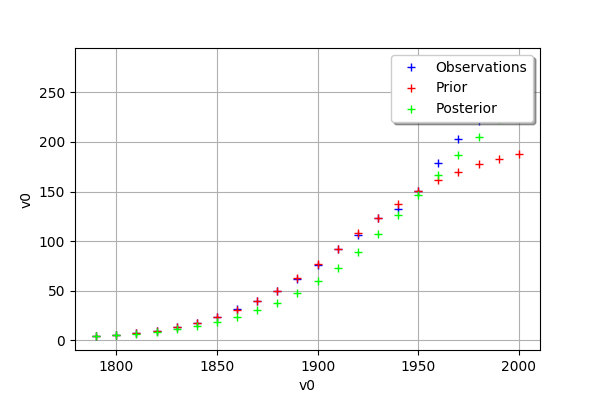

In [26]:
mypcr.drawObservationsVsInputs()

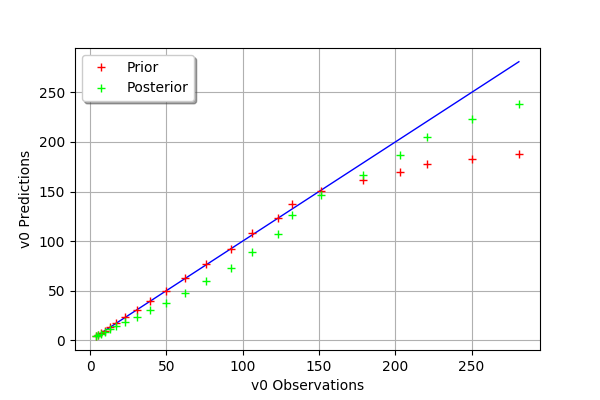

In [27]:
mypcr.drawObservationsVsPredictions()

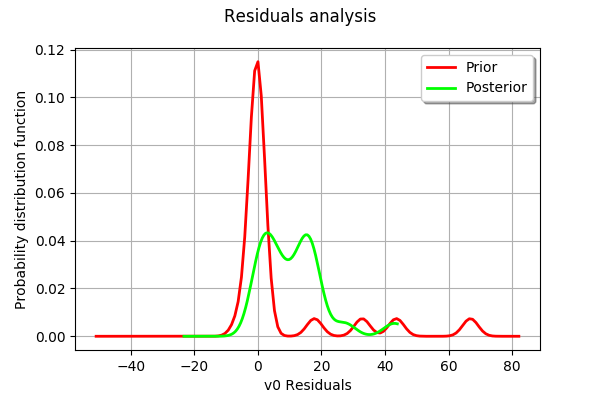

In [28]:
mypcr.drawResiduals()

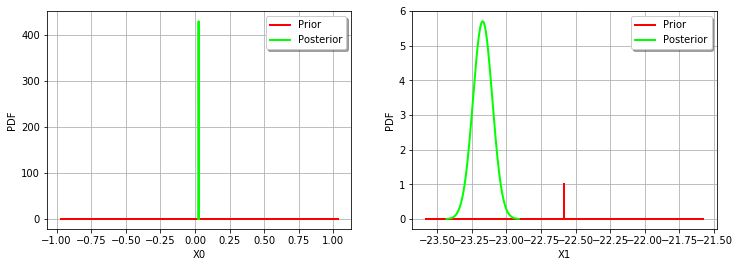

In [29]:
_ = mypcr.drawParameterDistributions()